# Notebook to analyze ProteinGroups.txt from MaxQuant

In [36]:
#preflight to load required packages
pkg_str <- c("imputeLCMD","ABarray","psych",
             "qvalue",'genefilter',"limma",
             "missForest","VIM","ggplot2","ggridges",
             "car","Hmisc","mice","stringr",
             "ggplot2","ggfortify","reshape2",
             'clusterProfiler', 'org.Hs.eg.db',
             'org.Mm.eg.db','Rgraphviz')
for(i in seq_along(pkg_str)) {
    suppressPackageStartupMessages(library(pkg_str[i],character.only = T))
}
#Utility functions
roundUp <- function(x,to=10)
{
  to*(x%/%to + as.logical(x%%to))
}

## Notebook Variables

In [37]:
datafile = "proteinGroups.txt"

min_num_observations = 3 # minimum number of observations per row

limma_norm = 'Quantile' #'Quantile','None'
ttest_norm = 'Trimmed Mean' #'Trimmed Mean','None'

impute_LCmnar = "TRUE" # impute missing not at random low abundance data sets
mnar_imputation = 'QRILC' #'MinDet' ,'QRILC'
mar_imputation = "" # add options for mar imputation

qvalue_threshold = 0.05
max_rows_to_display = 100
max_columns_to_display = 50

options(repr.matrix.max.cols=max_rows_to_display, repr.matrix.max.rows=max_columns_to_display)

## Load data and prepare for analysis

In [39]:
#Load Data
df = read.table(datafile,sep='\t',header=T)
colnames(df) = make.names(colnames(df))
df.counts = df[ , grepl( "LFQ" , colnames( df ) )]
colnames(df.counts) <- gsub('LFQ.intensity.','',colnames(df.counts))
df.counts = cbind(protid=df$Protein.IDs,df.counts)
cat("Use the following columns names for selection in next cell\n")
cat(paste('"',paste(colnames(df.counts),collapse='","'),'"',sep=""))

Use the following columns names for selection in next cell
"protid","t1.1","t1.2","t1.3","t1.4","t2.1","t2.2","t2.3","t2.4"

## Select columns for analysis and set column factor labels

In [40]:
selected_columns_a = c("t1.1","t1.2","t1.3","t1.4")
selected_columns_b = c("t2.1","t2.2","t2.3","t2.4")
fac <- c("T1",'T1','T1','T1',
         'T2','T2','T2','T2')

selected_columns = c("protid",selected_columns_a,selected_columns_b)

head(df.counts[selected_columns])

# Specify appropriate factor labes for the sample names above.
# Treatments must have the same name

cat("Factors for data table are:", paste(fac,collapse=","))

protid,t1.1,t1.2,t1.3,t1.4,t2.1,t2.2,t2.3,t2.4
sp|Q91VS7|MGST1_MOUSE,0,0,0,0,0,0,0,2008900
sp|Q8K224|NAT10_MOUSE,0,0,0,0,0,0,0,43861000
sp|Q8BH04|PCKGM_MOUSE,0,0,0,0,0,0,0,1443400
sp|Q9D5A9|RNS10_MOUSE,0,0,0,0,0,0,0,3499900
sp|Q9CPT5|NOP16_MOUSE,0,0,0,0,0,0,58035000,0
sp|Q7TQK4|EXOS3_MOUSE,0,0,0,0,0,0,0,13802000


Factors for data table are: T1,T1,T1,T1,T2,T2,T2,T2

## Filter rows that don't meet the minimum number of observations

In [41]:
df.counts.selected = df.counts[selected_columns]
cat(paste("number of row before filtering",nrow(df.counts.selected),"\n"))
df.counts.filtered = df.counts.selected[rowSums(df.counts.selected[,-1]>0) >= min_num_observations,]
cat(paste("number of row after filtering",nrow(df.counts.filtered)))

number of row before filtering 3165 
number of row after filtering 2409

# log2 tranform data and Examine missing values

No id variables; using all as measure variables


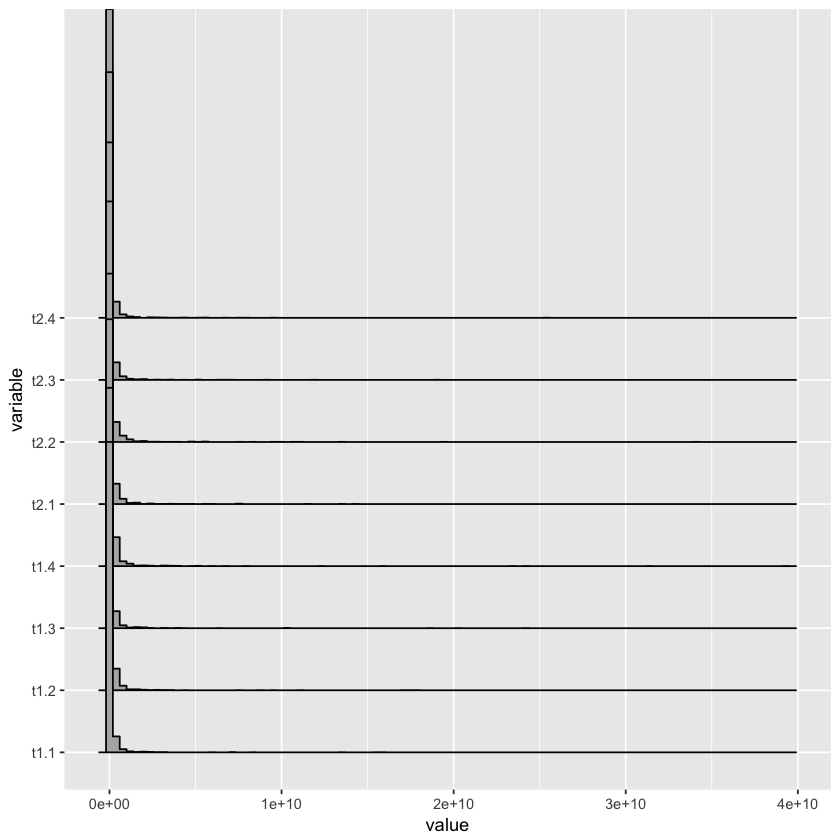

In [42]:
df.mis.raw <- subset(df.counts.filtered,select=-c(protid))
plot_raw1 = melt(df.mis.raw)
ggplot(plot_raw1, aes(x = value, y = variable, height = ..density..)) + 
  geom_density_ridges2(stat = "binline", bins = 100, scale = 5)

No id variables; using all as measure variables


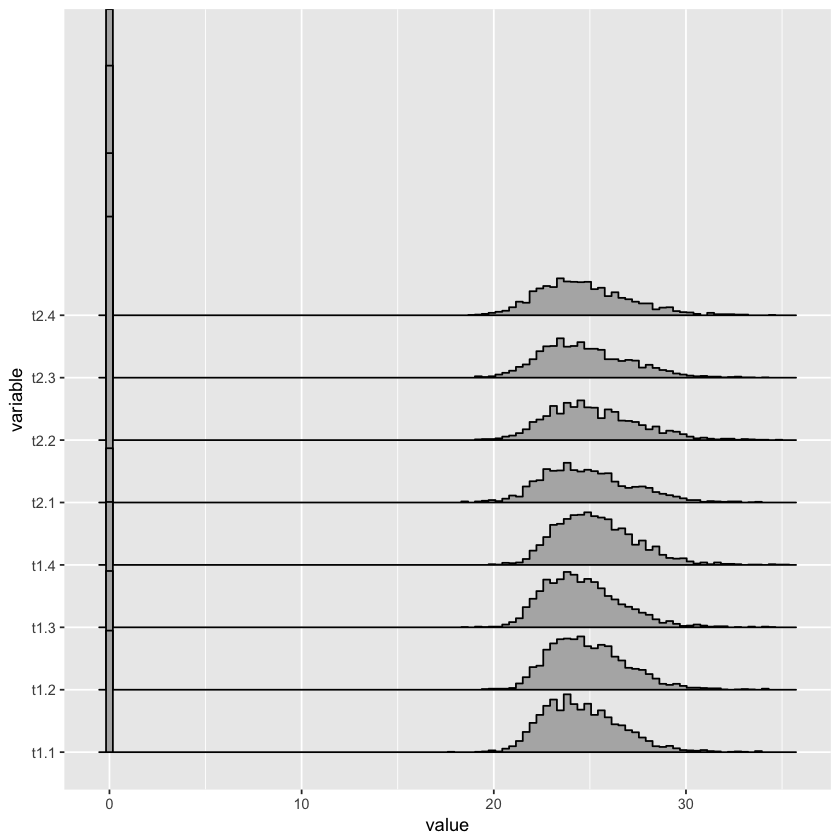

In [43]:
plot_raw2 = melt(log2(df.mis.raw))
plot_raw2[plot_raw2 == -Inf] <- 0

ggplot(plot_raw2, aes(x = value, y = variable, height = ..density..)) + 
  geom_density_ridges2(stat = "binline", bins = 100, scale = 5)

df.mis.raw.na = df.mis.raw
df.mis.raw.na[df.mis.raw.na == 0] <- NA

df.mis <- log2(df.mis.raw.na)

Warning message in plot.aggr(res, ...):
“not enough vertical space to display frequencies (too many combinations)”


 Variables sorted by number of missings: 
 Variable     Count
     t2.3 0.3719386
     t2.4 0.3648817
     t2.2 0.3420506
     t2.1 0.3408053
     t1.3 0.1494396
     t1.1 0.1448734
     t1.2 0.1415525
     t1.4 0.1390619


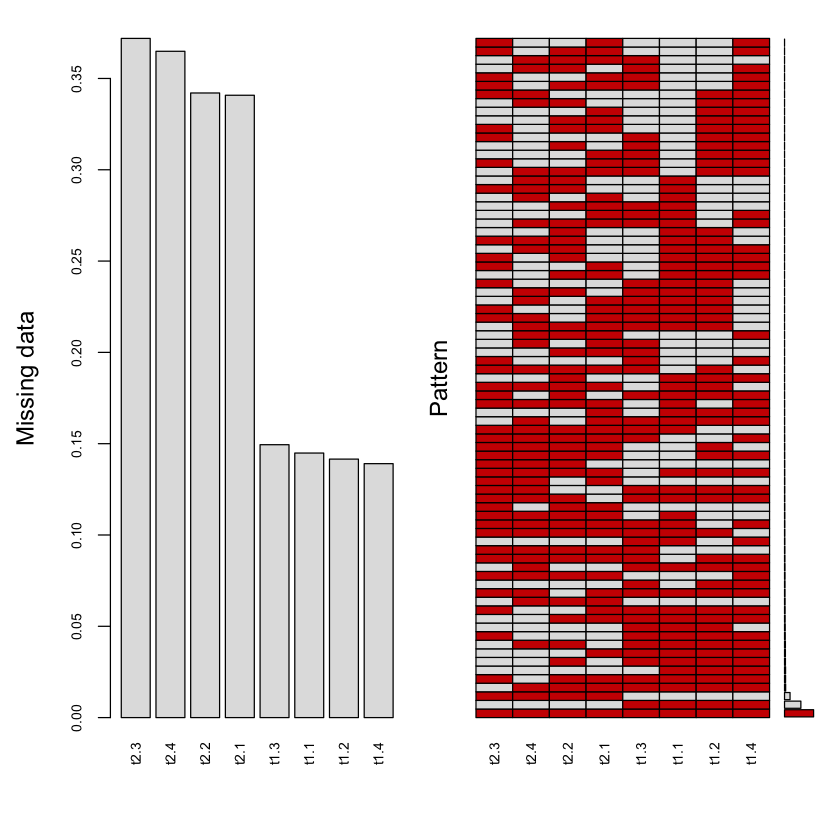

In [44]:
aggr(df.mis, col=c('red3','gray88'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(df.mis), cex.axis=.7,
                    gap=3, ylab=c("Missing data","Pattern"))

In [45]:
if (impute_LCmnar == TRUE) {
    m.s.a = model.Selector(df.mis[selected_columns_a])
    df.mis.imp1 = impute.MAR.MNAR(as.matrix(df.mis[selected_columns_a]), m.s.a,
                           method.MAR = "MLE", method.MNAR = mnar_imputation)

    m.s.b = model.Selector(df.mis[selected_columns_b])
    df.mis.imp2 = impute.MAR.MNAR(as.matrix(df.mis[selected_columns_b]), m.s.b,
                           method.MAR = "MLE", method.MNAR = mnar_imputation)
} else {
    df.mis.imp1 = impute.wrapper.MLE(as.matrix(df.mis[selected_columns_a]))
    df.mis.imp2 = impute.wrapper.MLE(as.matrix(df.mis[selected_columns_b])) 
}
    df.mis.imp.comb = cbind(df.mis.imp1,df.mis.imp2)

Picking joint bandwidth of 0.465


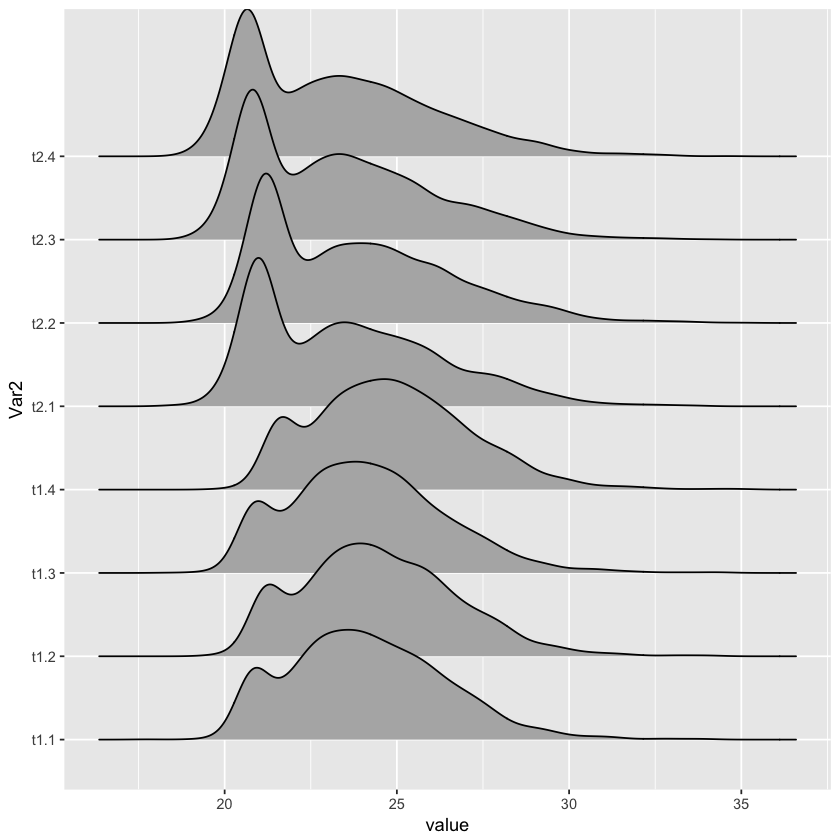

In [46]:
data2<- melt(df.mis.imp.comb)
ggplot(data2,aes(x=value, y=Var2)) + geom_density_ridges()

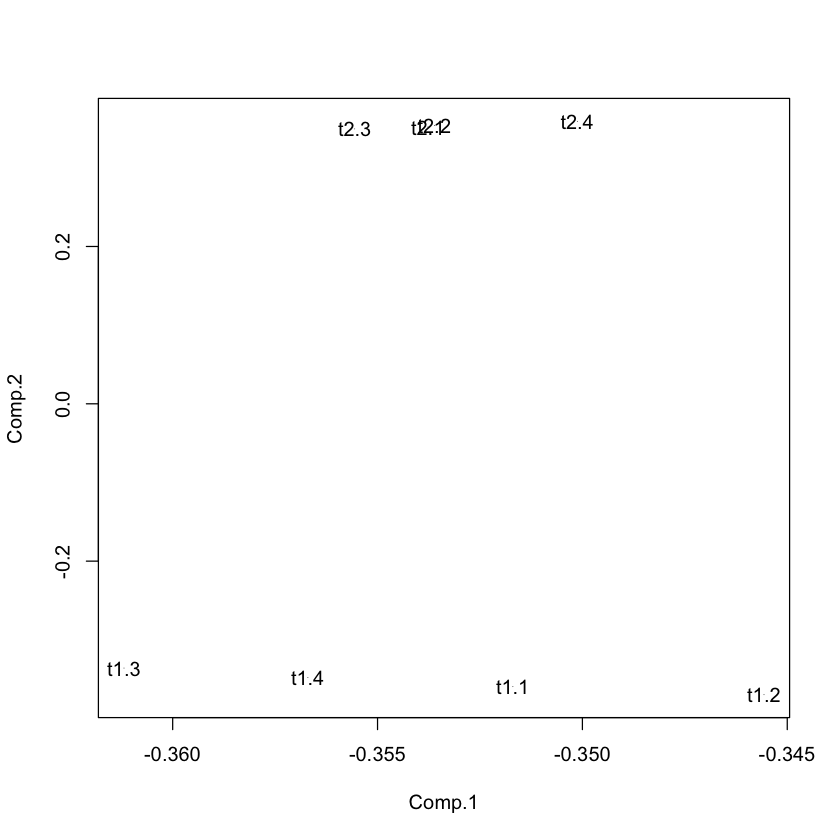

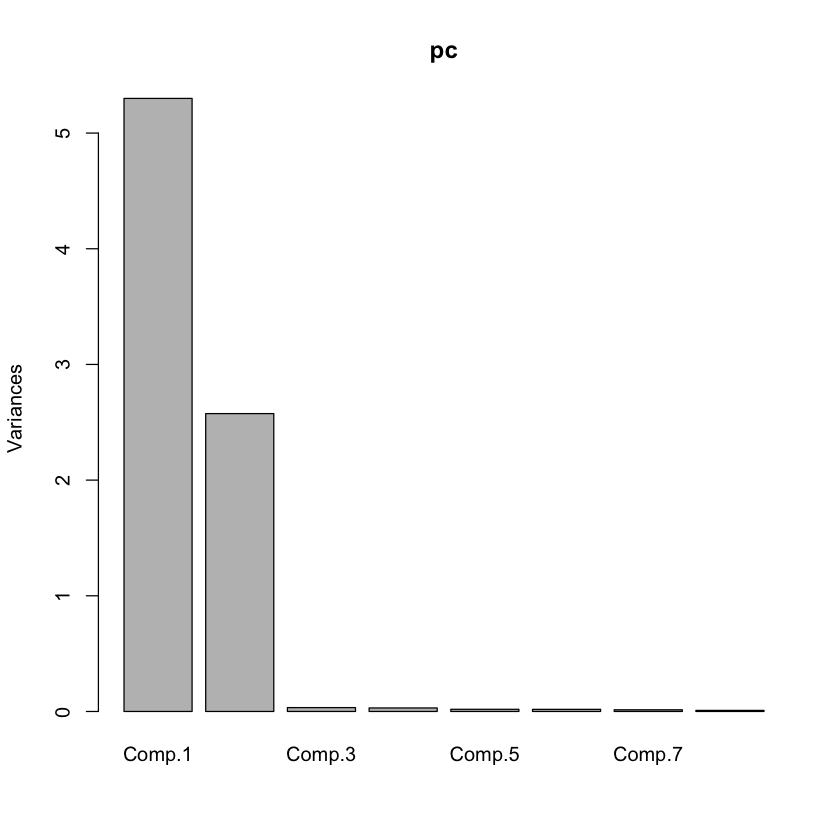

In [47]:
pc = princomp(df.mis.imp.comb,cor=T,scores=T)
plot(pc$loadings,pch=16,cex=0.1)
text(pc$loadings,labels=labels(pc$loadings[,1]))
screeplot(pc)


In [48]:
cat(ttest_norm)

if (ttest_norm == "Trimmed Mean") {
    trmean = apply(df.mis.imp.comb, 2, mean, trim=0.02)
    mean.of.trmeans = mean(trmean)
    df.mis.imp.norm <- df.mis.imp.comb / trmean * mean.of.trmeans
} else {
     df.mis.imp.norm <- df.mis.imp.comb
}

Trimmed Mean

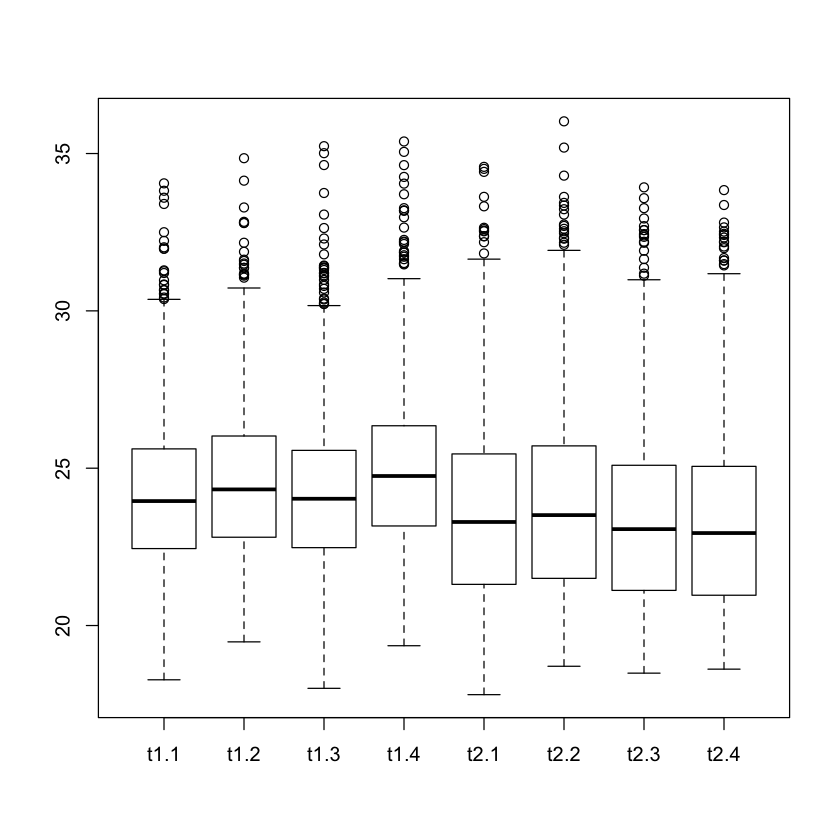

In [49]:
boxplot(df.mis.imp.norm)

In [50]:
# compute standard t-test
tt <-rowttests(as.matrix(df.mis.imp.norm),as.factor(fac))
pvalues1 <- tt$p.value
qobj1 <- qvalue(p = pvalues1)

qvalues1 <- qobj1$qvalues
pi01 <- qobj1$pi0
lfdr1 <- qobj1$lfdr

temp_cnames_imp <- colnames(df.mis.imp.comb) 
temp_cnames_norm <- colnames(df.mis.imp.norm) 
colnames(df.mis.imp.comb) <- paste(colnames(df.mis.imp.comb), "imp",sep = "_")
colnames(df.mis.imp.norm) <- paste(colnames(df.mis.imp.norm), "tmm_norm",sep = "_")

output_data1 = cbind(df.counts.filtered,df.mis.imp.comb,df.mis.imp.norm,tt)
output_data1['qvalue'] <- qvalues1
temp.ids = str_match(output_data1$protid,'^([a-z]*\\|([a-zA-Z0-9]*)\\|)([a-zA-Z0-9]*)_[a-zA-Z0-9]*')
colnames(temp.ids) <- c("Protein Description","UniprotID","UniprotAC","Protein Name")
output_data1 = cbind(temp.ids,output_data1[,c(-1)],protein.IDs=output_data1[,c(1)])

colnames(df.mis.imp.comb) <-  temp_cnames_imp 
colnames(df.mis.imp.norm) <-  temp_cnames_norm 

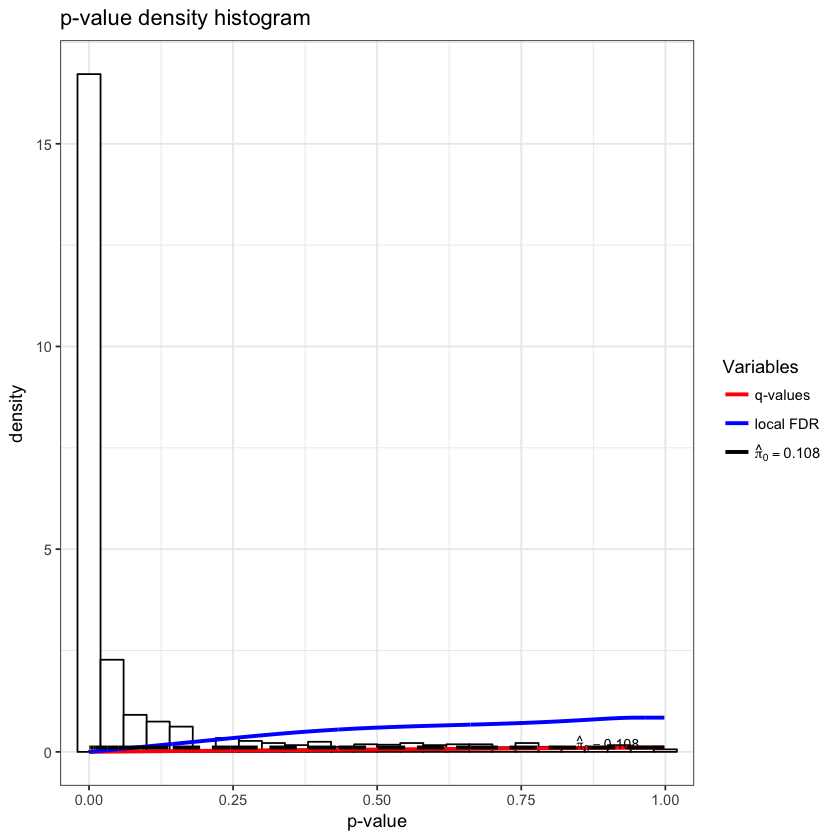

In [51]:
hist(qobj1)

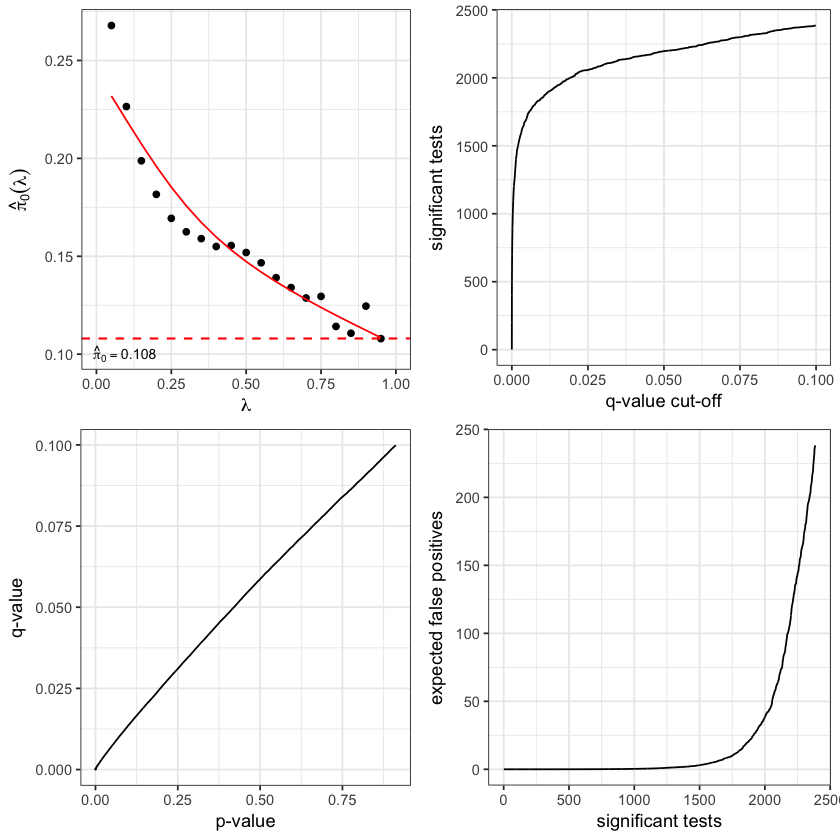

In [52]:
plot(qobj1)

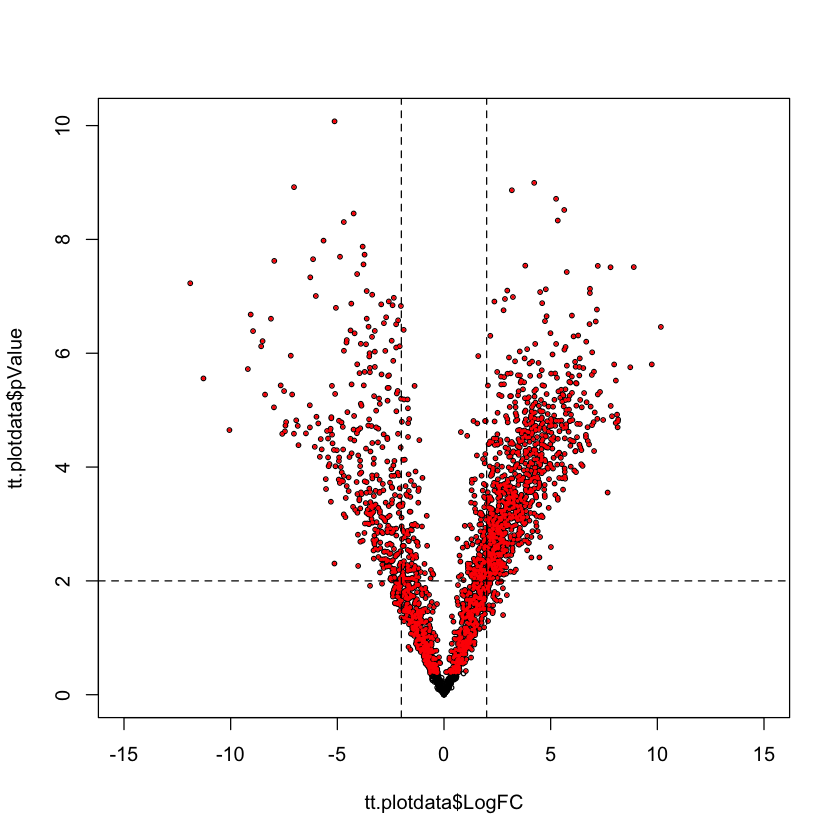

In [53]:
tt.plotdata = data.frame(cbind(LogFC = output_data1$dm,pValue = -log10(output_data1$p.value), qValue = output_data1$qvalue))
tt.plotdata.sig = tt.plotdata[tt.plotdata$qValue <= qvalue_threshold,]
tt.xlim = roundUp(max(abs(tt.plotdata.sig$LogFC)),5)
plot(tt.plotdata$LogFC,tt.plotdata$pValue,cex=.5,pch=21,xlim=c(-tt.xlim,tt.xlim))
points(tt.plotdata.sig$LogFC,tt.plotdata.sig$pValue,col="red",cex=.4,pch=16)
abline(h=2,v=c(-2,2), lty=2)

In [54]:
write.csv(output_data1[order(output_data1$p.value),],"output_ttest.csv")

In [55]:
view_data1 = output_data1[output_data1$qvalue <= qvalue_threshold,]
view_data1 = view_data1[order(view_data1$qvalue),]
view_data1[view_data1$dm < 0,]

,Protein Description,UniprotID,UniprotAC,Protein Name,t1.1,t1.2,t1.3,t1.4,t2.1,t2.2,t2.3,t2.4,t1.1_imp,t1.2_imp,t1.3_imp,t1.4_imp,t2.1_imp,t2.2_imp,t2.3_imp,t2.4_imp,t1.1_tmm_norm,t1.2_tmm_norm,t1.3_tmm_norm,t1.4_tmm_norm,t2.1_tmm_norm,t2.2_tmm_norm,t2.3_tmm_norm,t2.4_tmm_norm,statistic,dm,p.value,qvalue,protein.IDs
122,sp|Q9CQJ4|RING2_MOUSE,sp|Q9CQJ4|,Q9CQJ4,RING2,0,0,0,0,43637000,53865000,36672000,32625000,20.80481,21.08403,20.64869,21.49324,25.37905,25.68284,25.12818,24.95947,20.66159,20.63752,20.49857,20.71730,25.75935,25.82113,25.76272,25.69418,-96.35933,-5.130598,8.417916e-11,2.198941e-08,sp|Q9CQJ4|RING2_MOUSE;sp|O35730|RING1_MOUSE
1499,sp|Q62086|PON2_MOUSE,sp|Q62086|,Q62086,PON2,0,0,0,0,182230000,166350000,136730000,141070000,20.65055,21.17319,20.93088,21.53191,27.44119,27.30965,27.02675,27.07184,20.50839,20.72479,20.77871,20.75458,27.85239,27.45670,27.70925,27.86872,-61.79778,-7.030143,1.206915e-09,8.936815e-08,sp|Q62086|PON2_MOUSE
412,sp|Q91ZX7|LRP1_MOUSE,sp|Q91ZX7|,Q91ZX7,LRP1,685370000,840280000,736150000,1381200000,7637200000,9666800000,7241800000,5706800000,29.35231,29.64629,29.45542,30.36328,32.83040,33.17039,32.75370,32.41003,29.15025,29.01847,29.24129,29.26712,33.32236,33.34900,33.58081,33.36405,-51.73147,-4.234773,3.501237e-09,1.306569e-07,sp|Q91ZX7|LRP1_MOUSE
319,sp|Q9QZD8|DIC_MOUSE,sp|Q9QZD8|,Q9QZD8,DIC,257170000,301570000,296980000,482160000,4506700000,4760000000,3644900000,3006300000,27.93815,28.16792,28.14579,28.84494,32.06942,32.14831,31.76323,31.48534,27.74582,27.57140,27.94118,27.80360,32.54998,32.32142,32.56533,32.41214,-48.82466,-4.696719,4.949969e-09,1.436709e-07,sp|Q9QZD8|DIC_MOUSE
2295,sp|Q9R1P4|PSA1_MOUSE,sp|Q9R1P4|,Q9R1P4,PSA1,0,0,0,0,56729000,69097000,62749000,58406000,20.85859,21.30563,20.69429,21.51931,25.75758,26.04212,25.90309,25.79961,20.71500,20.85444,20.54385,20.74243,26.14356,26.18234,26.55720,26.55904,-43.05512,-5.646608,1.050681e-08,2.744606e-07,sp|Q9R1P4|PSA1_MOUSE
2728,sp|P06802|ENPP1_MOUSE,sp|P06802|,P06802,ENPP1,0,0,0,0,17722000,22287000,0,15924000,20.67368,21.03863,20.92197,21.62675,24.07904,24.40970,23.77741,23.92470,20.53136,20.59309,20.76987,20.84599,24.43986,24.54113,24.37785,24.62894,-41.34712,-3.811867,1.338560e-08,3.178734e-07,sp|P06802|ENPP1_MOUSE
112,sp|Q91VJ5|PQBP1_MOUSE,sp|Q91VJ5|,Q91VJ5,PQBP1,0,0,0,0,229010000,396870000,213010000,315690000,20.81915,20.94137,20.64386,21.62498,27.77084,28.56409,27.66635,28.23393,20.67583,20.49789,20.49378,20.84429,28.18698,28.71790,28.36499,29.06502,-37.54166,-7.955773,2.384404e-08,4.030069e-07,sp|Q91VJ5|PQBP1_MOUSE
336,sp|Q8VCX5|MICU1_MOUSE,sp|Q8VCX5|,Q8VCX5,MICU1,429530000,513830000,504950000,666230000,3503900000,4668700000,2840000000,2572200000,28.67818,28.93672,28.91157,29.31145,31.70631,32.12037,31.40324,31.26036,28.48076,28.32391,28.70138,28.25326,32.18143,32.29333,32.19625,32.18053,-36.65962,-3.773053,2.748513e-08,4.030069e-07,sp|Q8VCX5|MICU1_MOUSE
1069,sp|P21278|GNA11_MOUSE,sp|P21278|,P21278,GNA11,0,0,0,0,39082000,57781000,28745000,29694000,20.71001,21.29528,20.89549,21.60237,25.22000,25.78409,24.77681,24.82367,20.56744,20.84431,20.74359,20.82250,25.59792,25.92293,25.40248,25.55437,-38.61362,-4.874968,2.015033e-08,4.030069e-07,sp|P21278|GNA11_MOUSE
1271,sp|Q8K3C3|LZIC_MOUSE,sp|Q8K3C3|,Q8K3C3,LZIC,0,0,0,0,104030000,83202000,76531000,60545000,20.44657,21.11192,20.87783,21.47678,26.63242,26.31011,26.18954,25.85150,20.30581,20.66482,20.72605,20.70144,27.03151,26.45178,26.85089,26.61246,-37.97034,-6.137128,2.227932e-08,4.030069e-07,sp|Q8K3C3|LZIC_MOUSE


In [56]:
cat(limma_norm)
# perform quantile normalization of data points and then limma analysis
if (limma_norm == "Quantile") {
    exprSet.quantile = normalizeQuantiles(as.matrix((df.mis.imp.comb)))
} else {
     exprSet.quantile = as.matrix((df.mis.imp.comb))
}

Quantile

In [57]:
fit <- lmFit(as.matrix(exprSet.quantile), design=model.matrix(~ fac))

fit <- eBayes(fit)
tt <- topTable(fit, coef=2)

limmares <- data.frame(dm=coef(fit)[,2], p.value=fit$p.value[,2])

results <- decideTests(fit)
pvalues <- fit$p.value

qobj <- qvalue(p = pvalues[,2])

qvalues <- qobj$qvalues
pi0 <- qobj$pi0
lfdr <- qobj$lfdr

temp_cnames_imp <- colnames(df.mis.imp.comb) 
temp_cnames_norm <- colnames(exprSet.quantile) 
colnames(df.mis.imp.comb) <- paste(colnames(df.mis.imp.comb), "imp",sep = "_")
colnames(exprSet.quantile) <- paste(colnames(exprSet.quantile), "quant_norm",sep = "_")

#coef(fit)[,"facWT"]
output_data = cbind(df.counts.filtered,df.mis.imp.comb,exprSet.quantile,data.frame(topTable(fit,coef=2,sort="none",n=Inf)))
output_data['qvalue'] <- qvalues

temp.ids = str_match(output_data$protid,'^([a-z]*\\|([a-zA-Z0-9]*)\\|)([a-zA-Z0-9]*)_[a-zA-Z0-9]*')
colnames(temp.ids) <- c("Protein Description","UniprotID","UniprotAC","Protein Name")
output_data = cbind(temp.ids,output_data[,c(-1)],protein.IDs=output_data[,c(1)])
colnames(df.mis.imp.comb) <-  temp_cnames_imp 
colnames(exprSet.quantile) <-  temp_cnames_norm 

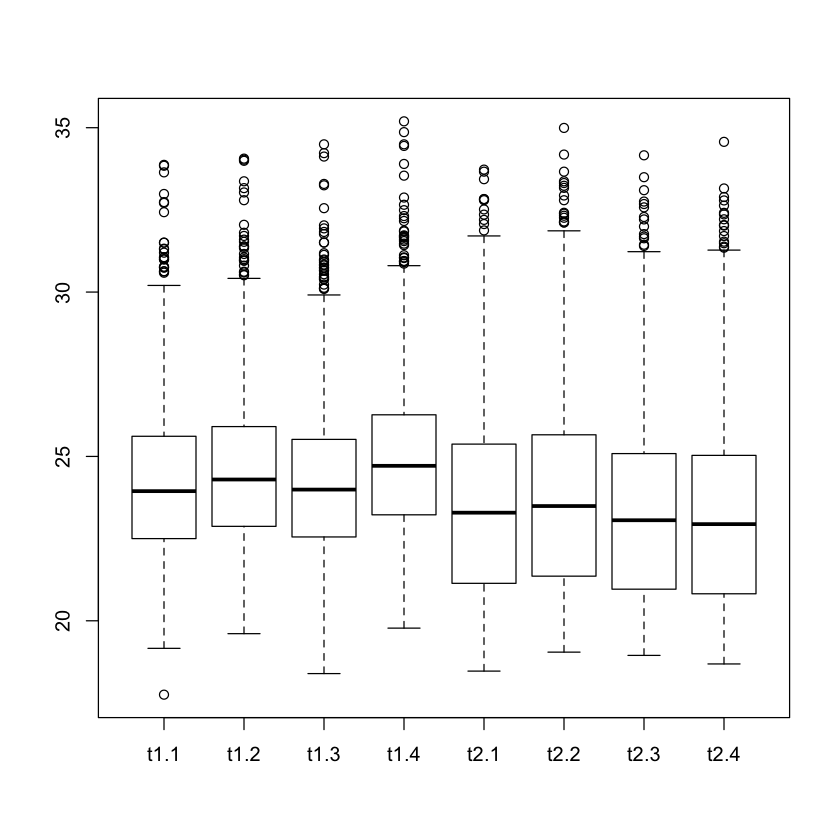

In [58]:
boxplot(as.matrix((df.mis.imp.comb)))

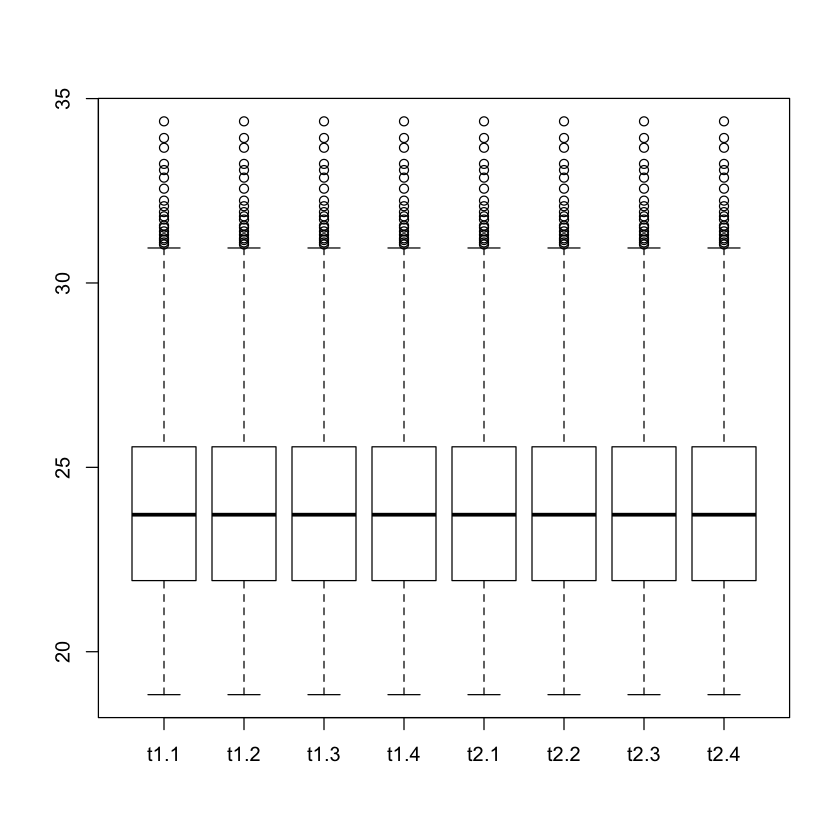

In [59]:
boxplot(exprSet.quantile)

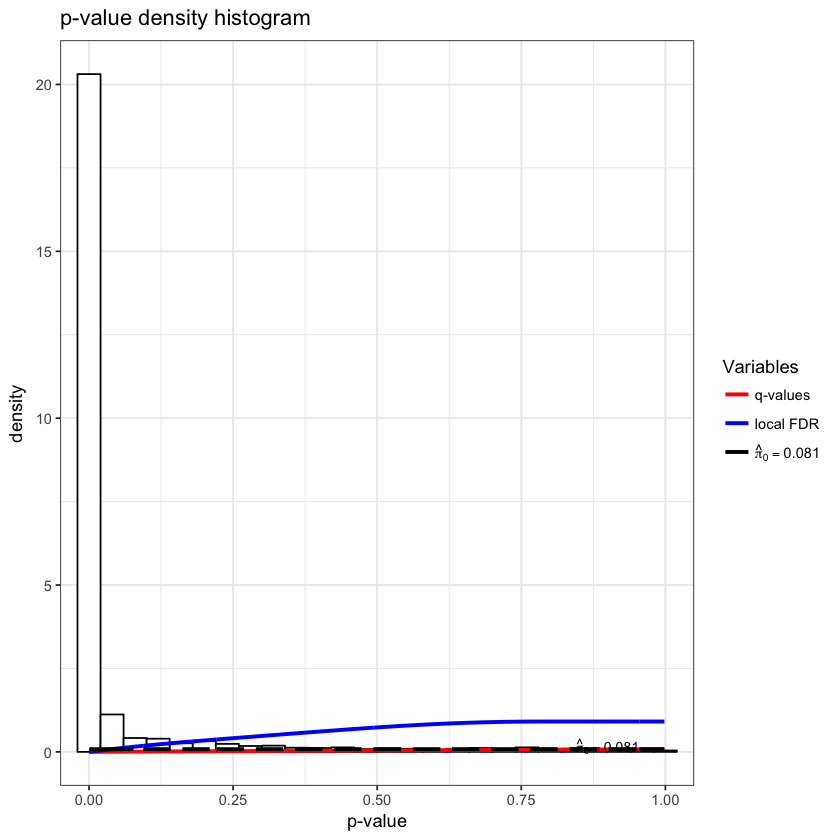

In [60]:
hist(qobj)

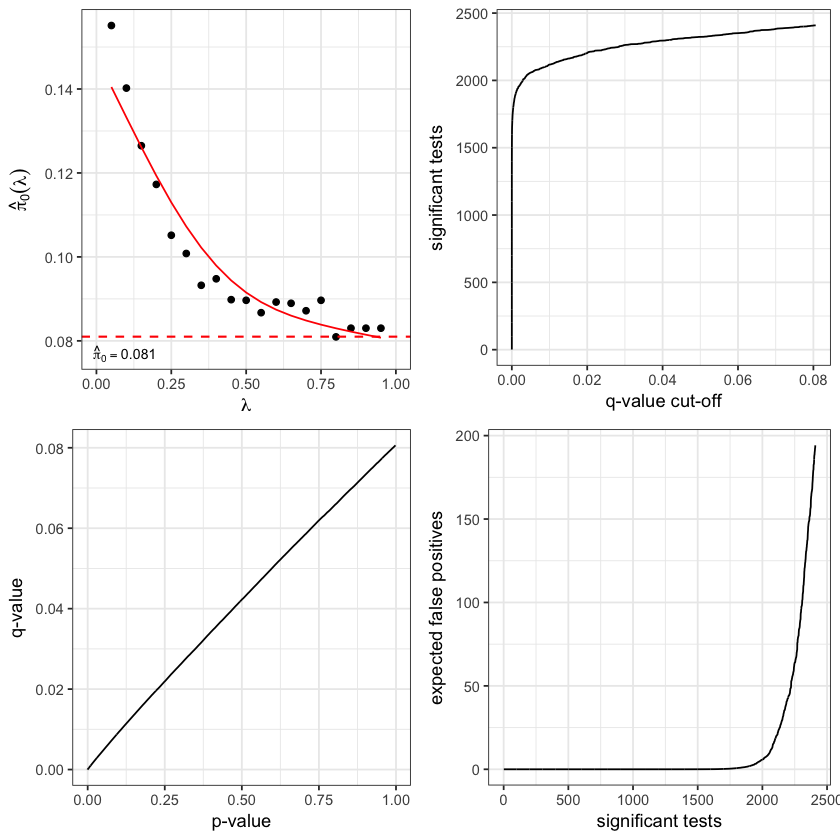

In [61]:
plot(qobj)

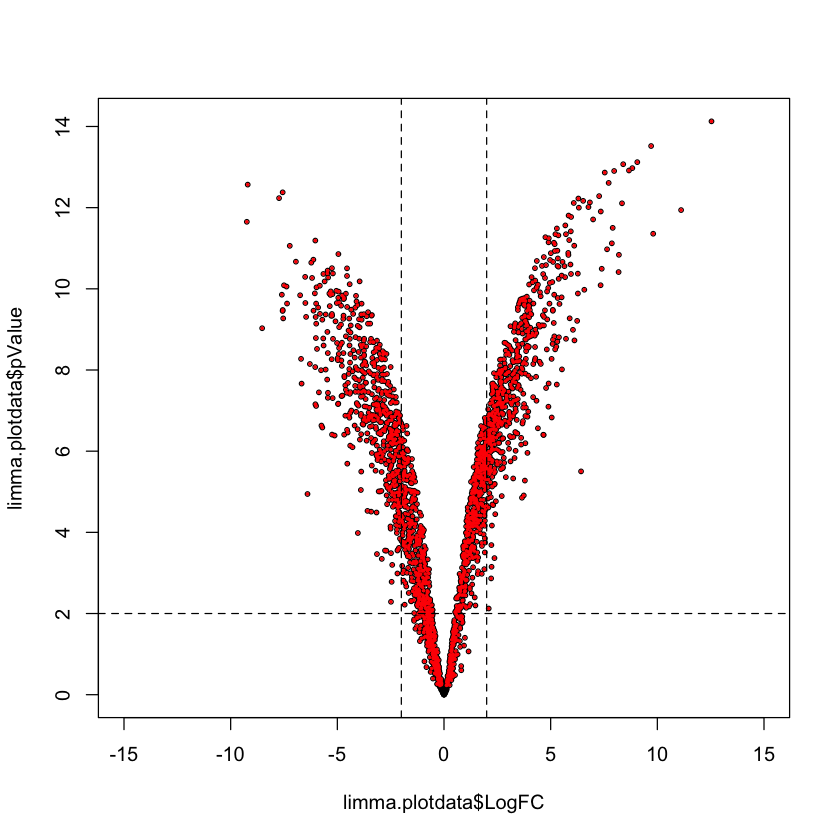

In [62]:
limma.plotdata = data.frame(cbind(LogFC = output_data$logFC,pValue = -log10(output_data$P.Value), qValue = output_data$qvalue))
limma.plotdata.sig = limma.plotdata[limma.plotdata$qValue <= qvalue_threshold,]
limma.xlim = roundUp(max(abs(limma.plotdata.sig$LogFC)),5)
plot(limma.plotdata$LogFC,limma.plotdata$pValue,cex=.5,pch=21,xlim=c(-limma.xlim,limma.xlim))
points(limma.plotdata.sig$LogFC,limma.plotdata.sig$pValue,col="red",cex=.4,pch=16)
abline(h=2,v=c(-2,2), lty=2)

In [63]:
write.csv(output_data[order(output_data$P.Value),],"output_limma.csv")

In [64]:
view_data = output_data[output_data$qvalue <= qvalue_threshold,]
view_data = view_data[order(view_data1$qvalue),]
view_data[view_data$logFC > 0,]

,Protein Description,UniprotID,UniprotAC,Protein Name,t1.1,t1.2,t1.3,t1.4,t2.1,t2.2,t2.3,t2.4,t1.1_imp,t1.2_imp,t1.3_imp,t1.4_imp,t2.1_imp,t2.2_imp,t2.3_imp,t2.4_imp,t1.1_quant_norm,t1.2_quant_norm,t1.3_quant_norm,t1.4_quant_norm,t2.1_quant_norm,t2.2_quant_norm,t2.3_quant_norm,t2.4_quant_norm,logFC,AveExpr,t,P.Value,adj.P.Val,B,qvalue,protein.IDs
33,sp|Q9WTU0|PHF2_MOUSE,sp|Q9WTU0|,Q9WTU0,PHF2,20827000,0,19358000,16249000,462980000,662700000,504040000,456780000,24.31195,24.79644,24.20643,23.95385,28.78637,29.30378,28.90896,28.76692,24.13876,24.27834,23.98783,22.76564,28.70235,28.82025,29.10951,28.71574,5.0443166,26.31480,16.4436277,5.323014e-09,3.684810e-08,11.332667,2.975266e-09,sp|Q9WTU0|PHF2_MOUSE
36,sp|Q62252|SP17_MOUSE,sp|Q62252|,Q62252,SP17,0,0,0,0,34696000,47234000,34640000,44295000,20.89357,21.04441,20.89335,21.58939,25.04827,25.49332,25.04594,25.40064,20.91371,20.54037,20.87283,20.83260,25.26077,25.47358,25.50108,25.85946,4.7338466,23.15680,25.3927895,5.403211e-11,1.496130e-09,15.774501,1.208037e-10,sp|Q62252|SP17_MOUSE
45,sp|O35685|NUDC_MOUSE,sp|O35685|,O35685,NUDC,0,0,0,0,107640000,80992000,94128000,84673000,20.68581,21.12723,20.78443,21.61263,26.68164,26.27128,26.48812,26.33540,20.58218,20.70185,20.68053,20.87965,26.74530,26.15691,26.76519,26.65550,5.8696726,23.64589,31.0511559,6.294080e-12,4.097956e-10,17.680014,3.308857e-11,sp|O35685|NUDC_MOUSE
47,sp|P62257|UBE2H_MOUSE,sp|P62257|,P62257,UBE2H,3764600,6505700,2585000,9690200,2276900,0,0,2820400,21.84407,22.63327,21.30173,23.20810,21.11864,21.48863,20.58993,21.42747,21.49802,21.77458,21.17527,21.92206,21.86916,22.17582,20.93798,22.52631,0.2848362,21.73490,0.8937518,3.908954e-01,4.144661e-01,-7.062494,3.346568e-02,sp|P62257|UBE2H_MOUSE
48,sp|P05213|TBA1B_MOUSE,sp|P05213|,P05213,TBA1B,0,0,0,0,87473000,127000000,74373000,93619000,20.41697,21.25850,20.85810,21.67418,26.38233,26.92025,26.14828,26.48030,20.13086,20.90234,20.78313,20.97738,26.50718,26.70678,26.45829,26.83501,5.9283858,23.66262,27.2800328,2.514539e-11,9.770202e-10,16.468381,7.888859e-11,sp|P05213|TBA1B_MOUSE;sp|P68373|TBA1C_MOUSE
51,sp|Q61686|CBX5_MOUSE,sp|Q61686|,Q61686,CBX5,0,0,0,7612100,16267000,9285300,17151000,7911500,22.07416,22.76088,21.65137,22.85986,23.95544,23.14652,24.03179,22.91552,21.65237,21.85467,21.38552,21.68294,24.32260,23.41462,24.63036,23.68549,2.3693923,22.82857,8.8941809,2.641213e-06,5.853433e-06,4.902052,4.726301e-07,sp|Q61686|CBX5_MOUSE
56,sp|Q9JJV2|PROF2_MOUSE,sp|Q9JJV2|,Q9JJV2,PROF2,848330,799180,653170,898300,2848100000,5604100000,2913400000,4363500000,19.69427,19.60816,19.31710,19.77684,31.40735,32.38384,31.44006,32.02284,19.48825,18.83526,19.36906,18.83526,31.39895,31.80729,31.55523,31.92153,12.5387934,25.40136,58.0742399,7.468962e-15,1.799273e-11,22.476790,1.452806e-12,sp|Q9JJV2|PROF2_MOUSE
64,sp|Q8VEM8|MPCP_MOUSE,sp|Q8VEM8|,Q8VEM8,MPCP,8751100,11012000,11003000,14080000,13923000,18495000,12279000,11656000,23.06103,23.39257,23.39139,23.74714,23.73097,24.14063,23.54969,23.47457,22.54422,22.47906,22.99316,22.46853,24.11094,24.25474,24.18325,24.17821,1.5605400,23.40151,8.8094309,2.895773e-06,6.359086e-06,4.805081,5.134586e-07,sp|Q8VEM8|MPCP_MOUSE
66,sp|P14211|CALR_MOUSE,sp|P14211|,P14211,CALR,52663000,60908000,42613000,88641000,0,41010000,46384000,0,25.65029,25.86013,25.34479,26.40147,26.00147,25.28947,25.46712,24.92543,25.62474,25.49302,25.35075,25.67952,26.12575,25.29717,25.89870,25.45534,0.1572295,25.61562,0.7357669,4.775151e-01,5.010165e-01,-7.194477,4.045412e-02,sp|P14211|CALR_MOUSE
67,sp|P56213|ALR_MOUSE,sp|P56213|,P56213,ALR,3243900,4376600,6310200,9620200,0,0,0,6673600,21.62930,22.06138,22.58925,23.19764,22.82047,23.07460,22.96227,22.67003,21.37942,21.41321,21.96139,21.91793,23.29902,23.35705,23.64493,23.47559,1.7761606,22.55607,8.9748365,2.421295e-06,5.415877e-06,4.993651,4.373000e-07,sp|P56213|ALR_MOUSE
